In this post I "invert" a simple two-layer MNIST model to visualize what the final hidden layer representations look like when projected back into the original sample space.

### Model Setup

This is a fully-connected model with two-hidden layers of 100 hidden neurons. The model also contains inverse weight matrices (`w2_inv` and `w1_inv`) that are trained after the fact by minimizing the l1 difference (`x_inv_similarity`) between the inverse projection of a sample and the original sample. 

In [1]:
import tensorflow as tf
import numpy as np
import load_mnist
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline
mnist = load_mnist.read_data_sets('MNIST_data', one_hot=True)
sess = tf.InteractiveSession()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
def weight_variable(shape,name=None):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial,name=name)
    
def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)


def logit(p):
    """element-wise logit of tensor p"""
    return tf.log(tf.div(p,1-p))

def squash(p, dim):
    """element-wise squash of dim of tensor MxN p to be between 0 and 1"""
    p_ = p - tf.reduce_min(p,dim,keep_dims=True) # add the minimum so all above 0 
    p_norm = (p_ / tf.reduce_max(p_,dim,keep_dims=True))
    p_norm_ = (p_norm - 0.5) * 0.99 + 0.5 #squashs to be strictly 0 < p_norm_ < 1
    return p_norm_
    

x = tf.placeholder("float", shape=[None, 784])
y_ = tf.placeholder("float", shape=[None, 10])

w1 = weight_variable([784,100])
b1 = bias_variable([100])
l1 = tf.nn.sigmoid(tf.matmul(x,w1) + b1) #100

w2 = weight_variable([100,100])
b2 = bias_variable([100])
l2 = tf.nn.sigmoid(tf.matmul(l1,w2) + b2) #100

w2_inv = weight_variable([100,100])
l1_inv = tf.matmul(logit(l2) - b2, w2_inv) 
l1_inv_norm = squash(l1_inv, 1)

# this "excess l1 inv" is minimized so as to try to get the l1_inv to be compatible 
# with the logit (inverse sigmoid) function without requiring the squash operation
excess_l1_inv = tf.nn.l2_loss(tf.reduce_min(l1_inv)) + tf.nn.l2_loss(tf.reduce_max(l1_inv - 1))

w1_inv = weight_variable([100,784])
x_inv = tf.matmul(logit(l1_inv_norm) - b1,w1_inv)

w = weight_variable([100,10])
b = bias_variable([10])
y = tf.nn.softmax(tf.matmul(l2,w) + b)

cross_entropy = -tf.reduce_sum(y_*tf.log(y))
x_inv_similarity = tf.reduce_sum(tf.abs(x - x_inv))

opt = tf.train.AdagradOptimizer(0.01)
grads = opt.compute_gradients(x_inv_similarity+excess_l1_inv, [w1_inv, w2_inv])
inv_train_step = opt.apply_gradients(grads)

train_step = tf.train.AdagradOptimizer(0.01).minimize(cross_entropy)

sess.run(tf.initialize_all_variables())

correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

### Training the Model

First, we train the model, and then we train the inverse operations. The model achieves an accuracy of about 95%. Because we don't want to confuse the inverse training with bad samples, we only train the model using samples that the model itself is confident it has classified correctly. This reduces noise in the inverse projections. 

In [3]:
for i in range(2000):
    batch = mnist.train.next_batch(1000)
    train_step.run(feed_dict={x: batch[0], y_: batch[1]})
    if i % 100 == 0:
        print(i,end=" ")
        print(accuracy.eval(feed_dict={x: mnist.test.images, 
                                       y_: mnist.test.labels}), end="\r")

In [4]:
for i in range(1000):
    batch = mnist.train.next_batch(1000)
    confidence = np.max(y.eval(feed_dict= {x: batch[0]}),axis=1)
    inv_train_step.run(feed_dict={x: batch[0][confidence>.8], y_: batch[1][confidence>.8]})
    if i % 100 == 0:
        print(i,end="\r")

In [5]:
print("Final Accuracy: " + str(accuracy.eval(feed_dict={x: mnist.test.images, 
                                       y_: mnist.test.labels})))

Final Accuracy: 0.9521


In [6]:
saver = tf.train.Saver()
saver.save(sess, "inverse_nn_save")

'inverse_nn_save'

### Visualizing inverse projections

We now show a visual comparison of the first 36 test samples and their projections. 

In [7]:
def plot_nxn(n, images):
    images = images.reshape((n*n,28,28))
    fig = plt.figure(1, (n, n))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(n, n),  # creates grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                     )

    for i in range(n*n):
        grid[i].imshow(images[i], cmap = cm.Greys_r)  # The AxesGrid object work as a list of axes.

    plt.show()

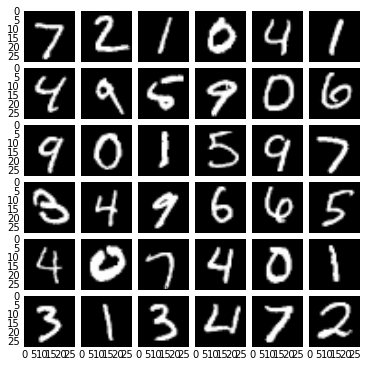

In [8]:
plot_nxn(6,mnist.test.images[:36])

In [9]:
x1 = x_inv.eval(feed_dict={x: mnist.test.images})[:36]

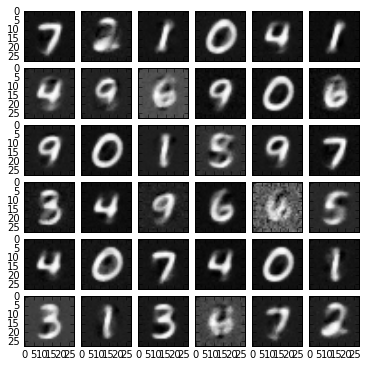

In [10]:
plot_nxn(6,x1)

I think the most interesting this about this is how the model completely transforms the misclassified digits. For example, the 9th sample and the 3rd to last sample each get transformed to a 6. 

It's also interesting that the inverse projections are somewhat "idealized" versions of each digit. For example, the orientations of the inversely projected 3s and 9s and the stroke width of the inversely projected 0s are now all the same.

### Generating samples

Here we generate samples of digits 1-9 by first optimizing the hidden representation so that the neural network is confident that the representaton is of a specific class, and then outputting the inverse projection.

In [11]:
def generate(n_samples,fake_labels):
    global w
    global b
    fake_l2 = tf.Variable(tf.zeros([n_samples, 100]))
    fake_y = tf.nn.softmax(tf.matmul(tf.nn.sigmoid(fake_l2),w) + b)
    fake_labels = tf.constant(fake_labels)
    diff = tf.reduce_sum(tf.abs(fake_labels - fake_y))
    #train the fake_l2 to minimize diff
    opt = tf.train.GradientDescentOptimizer(1.)
    grads = opt.compute_gradients(diff, [fake_l2])
    tstep = opt.apply_gradients(grads)
    sess.run(tf.initialize_variables([fake_l2]))

    for i in range(1000):
        tstep.run()
    
    fake_l1_inv = tf.matmul(fake_l2 - b2, w2_inv) 
    fake_l1_inv_norm = squash(fake_l1_inv,1)
    fake_x_inv = tf.matmul(logit(fake_l1_inv_norm) - b1,w1_inv)

    return fake_x_inv.eval(), fake_y.eval()

In [12]:
genned, fakes = generate(9, np.eye(10)[[1,2,3,4,5,6,7,8,9]].astype("float32"))

Here we see that the network is over 99.5% confident that each of its hidden layer representations are good representations. Below that we see their inverse projections. 

In [13]:
np.max(fakes,axis=1)

array([ 0.99675035,  0.99740452,  0.99649602,  0.99652439,  0.99734575,
        0.99607605,  0.99735802,  0.99755549,  0.99680138], dtype=float32)

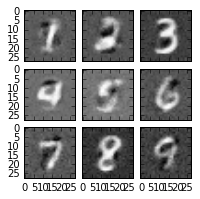

In [14]:
plot_nxn(3,genned)

A bit noisy, but it works!

### Visualizing Features

We will now show the inverse projection of each of the 100 features of the hidden representation, to get an idea of what the neural network has learned. Unfortunately, the noise is overwhelming, but we can sort of make out shadows of the learned features.

In [15]:
def generate_features():
    fake_l2 = tf.constant(np.eye(100).astype("float32")*(1e8))    
    fake_l1_inv = tf.matmul(fake_l2 - b2, w2_inv) 
    fake_l1_inv_norm = squash(fake_l1_inv,1)
    fake_x_inv = tf.matmul(logit(fake_l1_inv_norm) - b1,w1_inv)
    return fake_x_inv.eval()

In [16]:
genned = generate_features()

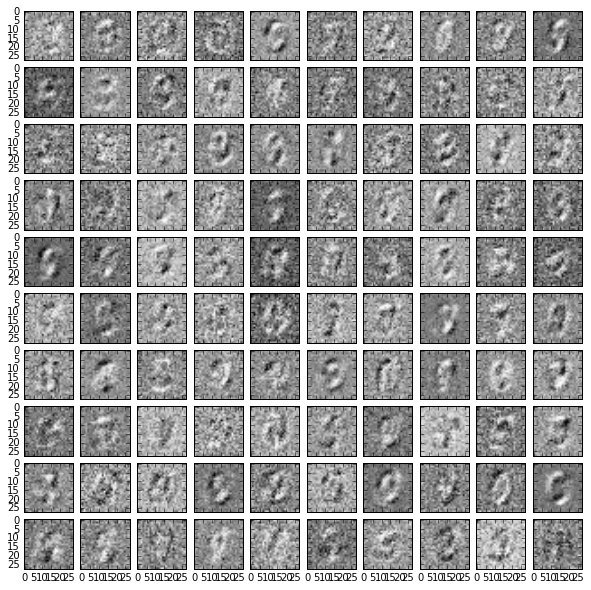

In [17]:
plot_nxn(10,np.round(genned,1))